In [16]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import StackingClassifier
import warnings
warnings.filterwarnings("ignore")

In [2]:
train_data = pd.read_csv('train_data.csv')
test_data = pd.read_csv('test_data.csv')

In [3]:
#pipeline do obróbki danych
cols_numerical = ['battery_power', 'blue', 'clock_speed', 'dual_sim', 'fc', 'four_g',
       'int_memory', 'm_dep', 'mobile_wt', 'n_cores', 'pc', 'px_height',
       'px_width', 'ram', 'sc_h', 'sc_w', 'talk_time', 'three_g',
       'touch_screen', 'wifi']

transformer_numerical = Pipeline(steps = [
    ('num_trans', MinMaxScaler())
])

preprocessor = ColumnTransformer(transformers = [
    ('numerical', transformer_numerical, cols_numerical)
])

pipe = Pipeline(steps = [
                ('preprocessor', preprocessor)
            ])

In [4]:
scaled_train_data = pipe.fit_transform(train_data)
X_train = pd.DataFrame(scaled_train_data, columns=cols_numerical)
y_train = train_data['price_range'].values.ravel()
scaled_test_data = pipe.fit_transform(test_data)
X_test = pd.DataFrame(scaled_test_data, columns=cols_numerical)
y_test = test_data['price_range'].values.ravel()

In [6]:
#łączymy px height i width
X_train2 = X_train
X_test2 = X_test
X_train2['px_area'] = X_train['px_height'] * X_train['px_width']
X_test2['px_area'] = X_test['px_height'] * X_test['px_width']
X_train2 = X_train2[['battery_power', 'px_area', 'ram']]
X_test2 = X_test2[['battery_power', 'px_area', 'ram']]

In [7]:
# łączymy ze sobą dane treningowe i testowe do crossvalidation
X = pd.concat([X_test, X_train], axis=0)
y = np.concatenate([y_test, y_train])
# łączymy ze sobą dane treningowe i testowe do crossvalidation
X2 = pd.concat([X_test2, X_train2], axis=0)
y2 = np.concatenate([y_test, y_train])


In [19]:
final_model = LogisticRegression(max_iter=6000, solver='saga', penalty = 'none', C = 0.001, l1_ratio = 0.1 )
knn = ('knn', KNeighborsClassifier(n_neighbors=7, weights='distance'))
svm = ('svm', SVC(C=1))
decision_tree = ('decision_tree', DecisionTreeClassifier(max_depth=20))


stacked_model = StackingClassifier(
    estimators=[knn, svm, decision_tree],
    final_estimator=LogisticRegression()
)


In [37]:
cv_scores1 = cross_val_score(final_model, X, y, cv=8, scoring='accuracy')
cv_scores2 = cross_val_score(stacked_model, X2, y2, cv=8, scoring='accuracy')

In [38]:
print(f'Cross-validation scores for Logistic Regression: {cv_scores1}')
print(f'Mean cross-validation accuracy for Logistic Regression: {cv_scores1.mean()}')
print(f'Cross-validation scores for Stacked Model: {cv_scores2}')
print(f'Mean cross-validation accuracy for Stacked Model: {cv_scores2.mean()}')

Cross-validation scores for Logistic Regression: [0.992 0.964 0.98  0.976 0.968 0.964 0.948 0.98 ]
Mean cross-validation accuracy for Logistic Regression: 0.9715
Cross-validation scores for Stacked Model: [0.98  0.94  0.96  0.944 0.916 0.944 0.904 0.92 ]
Mean cross-validation accuracy for Stacked Model: 0.9385


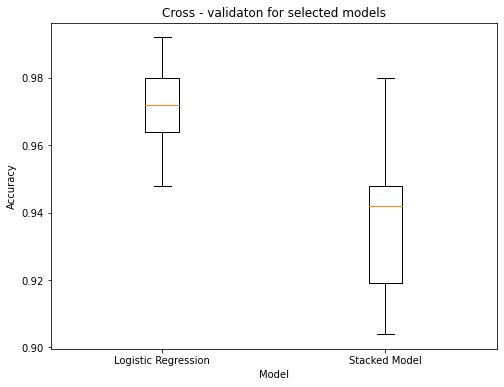

In [52]:
all_cv_scores = [cv_scores1, cv_scores2]


labels = ['Logistic Regression', 'Stacked Model']


plt.figure(figsize=(8, 6))
plt.boxplot(all_cv_scores, labels=labels)
plt.title('Cross - validaton for selected models')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.savefig('cross_validation.png', dpi = 300)

In [41]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

y_pred_final = cross_val_predict(final_model, X, y, cv=7)

# Oblicz macierz pomyłek dla final_model
cm_final = confusion_matrix(y, y_pred_final)



y_pred_stacked = cross_val_predict(stacked_model, X2, y2, cv=7)

cm_stacked = confusion_matrix(y, y_pred_stacked)


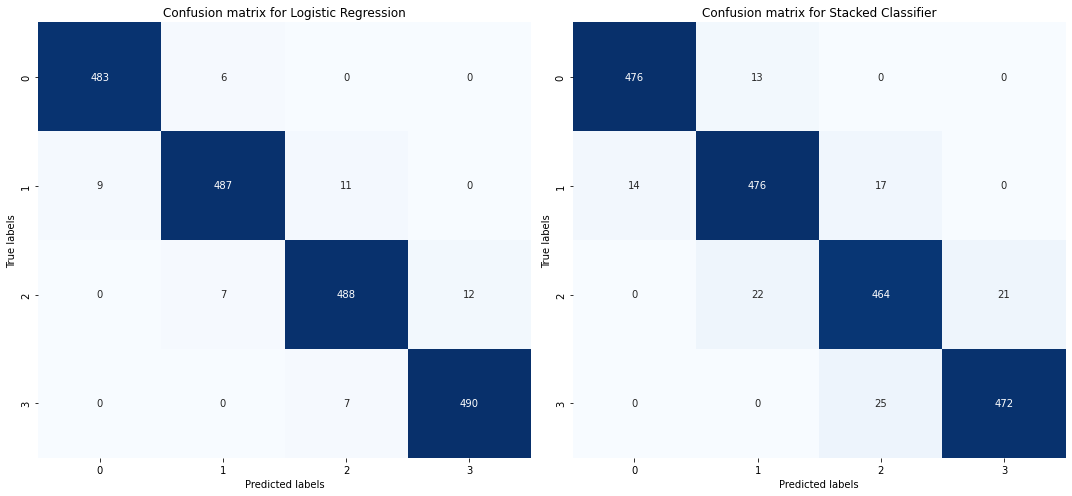

In [53]:
fig, axs = plt.subplots(1, 2, figsize=(15, 7))

# Plot dla final_model
sns.heatmap(cm_final, annot=True, cmap='Blues', fmt='d',cbar = False, ax=axs[0])
axs[0].set_title('Confusion matrix for Logistic Regression')
axs[0].set_xlabel('Predicted labels')
axs[0].set_ylabel('True labels')

# Plot dla stacked_model
sns.heatmap(cm_stacked, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axs[1])
axs[1].set_title('Confusion matrix for Stacked Classifier')
axs[1].set_xlabel('Predicted labels')
axs[1].set_ylabel('True labels')

plt.tight_layout()
plt.savefig('confusion_matrices.png', dpi = 300)